
====== Original content created by Cam Davidson-Pilon
Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)

### Coin-flipping example

Suppose, naively, that you are unsure about the probability of heads in a coin flip (spoiler alert: it's 50 \%). You believe there is some true underlying ratio, call it $p$, but have no prior opinion on what $p$ might be.

We begin to flip a coin, and record the observations: either $H$ or $T$. This is our observed data. An interesting question to ask is how our inference changes as we observe more and more data? More specifically, what do our posterior probabilities look like when we have little data, versus when we have lots of data.

Below we plot a sequence of updating posterior probabilities as we observe increasing amounts of data (coin flips).

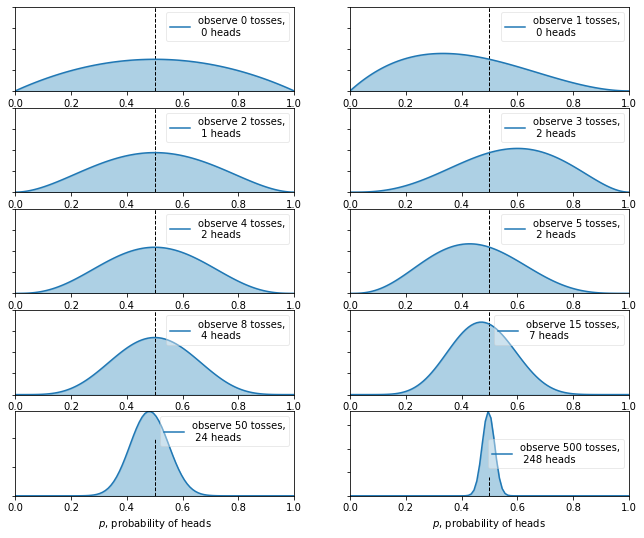

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# # For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(int(len(n_trials) / 2), 2, k + 1)
    plt.xlabel("$p$, probability of heads") 
    #if k in [0, len(n_trials) - 1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads+1, 1 + N - heads+1) #by varying parameters of the beta distribution we can see how prior influences posterior
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)

### Continuous distributions

An example of continuous random variable is a random variable with *exponential density*. The density function for an exponential random variable looks like this:

$p_X(x|\lambda)=\lambda e^{-\lambda x}$


An exponential random variable can take on *any* non-negative values. This property makes it a poor choice for count data, which must be an integer, but a great choice for time data, temperature data (measured in Kelvins, of course), or any other precise *and positive* variable. The graph below shows two probability density functions with different $\lambda$ values. 

When a random variable $X$ has an exponential distribution with parameter $\lambda$, we say *$X$ is exponential* and write

$$X\sim \text{Exp}(\lambda)$$

Given a specific $\lambda$, the expected value of an exponential random variable is equal to the inverse of $\lambda$, that is:

$$E[\; X \;|\; \lambda \;] = \frac{1}{\lambda}$$

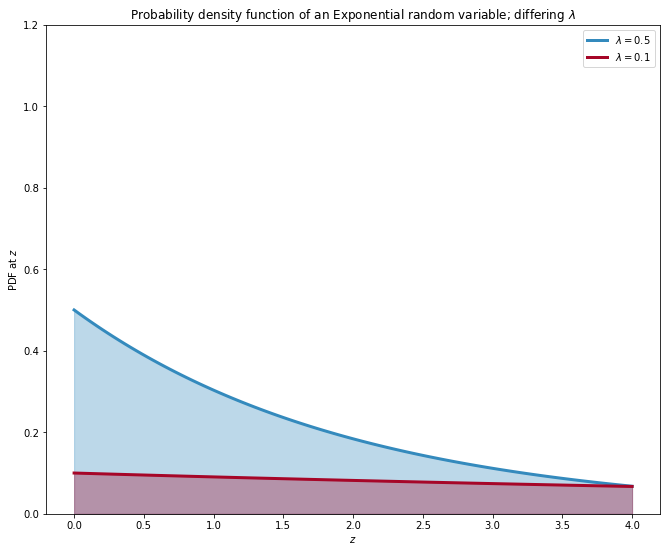

In [2]:
import scipy.stats as stats
a = np.arange(16)
colours = ["#348ABD", "#A60628"]

a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 0.1] #vary lambda to see other types of distributions

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1. / l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1. / l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0, 1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

### But what is $\lambda \;$?


Bayesian inference is concerned with *beliefs* about what $\lambda$ might be. Rather than try to guess $\lambda$ exactly, we can only talk about what $\lambda$ is likely to be by assigning a probability distribution to $\lambda$.

This might seem odd at first. After all, $\lambda$ is fixed; it is not (necessarily) random! How can we assign probabilities to values of a non-random variable? Ah, we have fallen for our old, frequentist way of thinking. Under Bayesian philosophy, we *can* assign probabilities if we interpret them as beliefs. And it is entirely acceptable to have *beliefs* about the parameter $\lambda$. 

Besides that, once we have a distribution we can always derive a point estimate out of it

##### Example: Inferring behaviour from text-message data

Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages:

>  You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this? 

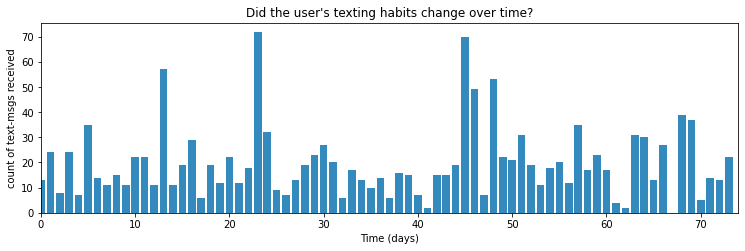

In [3]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

Before we start modeling, see what you can figure out just by looking at the chart above. Would you say there was a change in behaviour during this time period? 

How can we start to model this?

The count data are discrete and hence for modelling them a discrete distribution would be more appropriate.

A fairly generic distribution for modelling count data is the Poisson distribution. It is defined as

$$P(X = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots, \; \; \lambda \in \mathbb{R}_{>0} $$

$\lambda$ is called a parameter of the distribution, and it controls the distribution's shape. For the Poisson distribution, $\lambda$ can be any positive number. By increasing $\lambda$, we add more probability to larger values, and conversely by decreasing $\lambda$ we add more probability to smaller values. One can describe $\lambda$ as the *intensity* of the Poisson distribution. 

Unlike $\lambda$, which can be any positive number, the value $k$ in the above formula must be a non-negative integer, i.e., $k$ must take on values 0,1,2, and so on. 

If a random variable $X$ has a Poisson mass distribution, we denote this by writing

$$X \sim \text{Poi}(\lambda) $$

One useful property of the Poisson distribution is that its expected value is equal to its parameter, i.e.:

$$E\large[ \;X\; | \; \lambda \;\large] = \lambda $$

We will use this property often, so it's useful to remember. Below, we plot the probability mass distribution for different $\lambda$ values. The first thing to notice is that by increasing $\lambda$, we add more probability of larger values occurring. Second, notice that although the graph ends at 15, the distributions do not. They assign positive probability to every non-negative integer.



Text(0.5, 1.0, 'Probability mass function of a Poisson random variable; differing $\\lambda$ values')

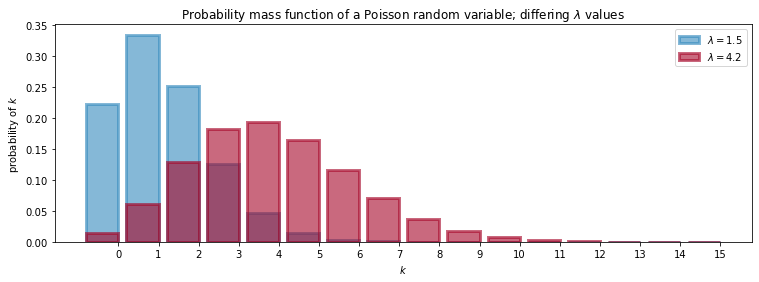

In [4]:
figsize(12.5, 4)

import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colours = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
         label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
         edgecolor=colours[0], 
        lw=3
       )

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
         label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw=3)

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values")

Coming back to the text message task, one can see that a Poisson random variable would be a very appropriate model for this type of *count* data. Denoting day $i$'s text-message count by $C_i$, 

$$ C_i \sim \text{Poisson}(\lambda)  $$

We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the chart above, it appears that the rate might become higher late in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations. (Recall that a higher value of $\lambda$ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)

How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *change-point*:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice.  A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 


What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

Given all the information above combined with the Bayes rule we can rigorously derive overall prior distribution of the parameters as well as the likelihood, however given that this course concentrates more on deploying Bayesian models rather than on mathematical aspects of them we will omit this part in order to save time and turn immediately to PyMC, a Python library for performing Bayesian analysis.


Introducing our first hammer: PyMC
-----

PyMC is a Python library for programming Bayesian analysis [3]. It is a fast, well-maintained library. 

We will model the problem above using PyMC. This type of programming is called *probabilistic programming*.

B. Cronin [5] has a very motivating description of probabilistic programming:

>   Another way of thinking about this: unlike a traditional program, which only runs in the forward directions, a probabilistic program is run in both the forward and backward direction. It runs forward to compute the consequences of the assumptions it contains about the world (i.e., the model space it represents), but it also runs backward from the data to constrain the possible explanations. In practice, many probabilistic programming systems will cleverly interleave these forward and backward operations to efficiently home in on the best explanations.


PyMC code is easy to read. The only novel thing should be the syntax, and I will interrupt the code to explain individual sections. Simply remember that we are representing the model's components ($\tau, \lambda_1, \lambda_2$ ) as variables:

In [5]:
import pymc3 as pm

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    #tau = pm.DiscreteUniform("tau", lower=0, upper=44)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data-1)

In the code above, we create the PyMC3 variables corresponding to $\lambda_1$ and $\lambda_2$. We assign them to PyMC3's *stochastic variables*, so-called because they are treated by the back end as random number generators.

In [6]:
with model:
    #idx = np.arange(n_count_data) # Index
    idx=np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

This code creates a new function `lambda_`, but really we can think of it as a random variable: the random variable $\lambda$ from above. The `switch()` function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on. The values of `lambda_` up until `tau` are `lambda_1` and the values afterwards are `lambda_2`.

Note that because `lambda_1`, `lambda_2` and `tau` are random, `lambda_` will be random. We are **not** fixing any variables yet.

In [7]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

The variable `observation` combines our data, `count_data`, with our proposed data-generation scheme, given by the variable `lambda_`, through the `observed` keyword. 

The machinery employed below for inference is called *Markov Chain Monte Carlo* (MCMC), later we will talk about it in detail. This technique returns thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$. We can plot a histogram of the random variables to see what the posterior distributions look like. Below, we collect the samples (called *traces* in the MCMC literature) into histograms.

In [8]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step,
                      return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

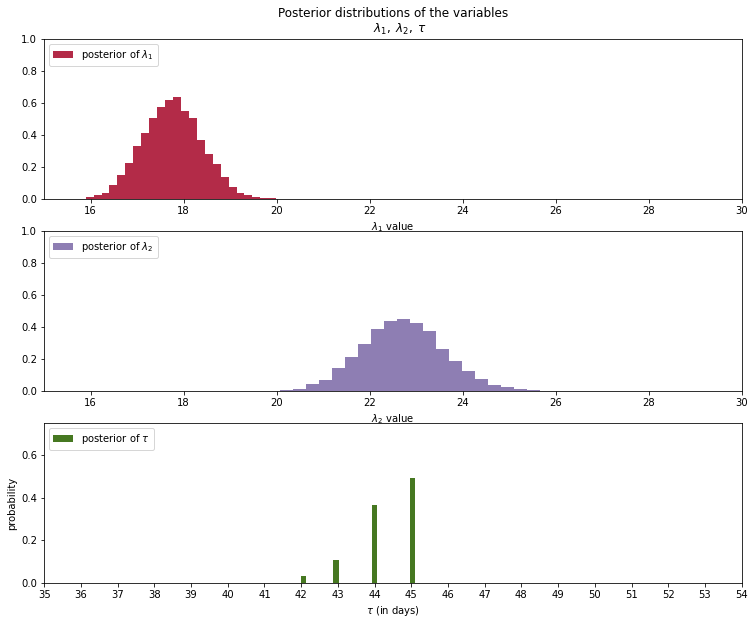

In [10]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

### Interpretation

Recall that Bayesian methodology returns a *distribution*. Hence we now have distributions to describe the unknown $\lambda$s and $\tau$. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: $\lambda_1$ is around 18 and $\lambda_2$ is around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.

What other observations can you make? If you look at the original data again, do these results seem reasonable? 

Notice also that the posterior distributions for the $\lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. But that's OK! This is one of the benefits of taking a computational point of view. If we had instead done this analysis using mathematical approaches, we would have been stuck with an analytically intractable (and messy) distribution. Our use of a computational approach makes us indifferent to mathematical tractability.

Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a discrete random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of $\tau$ would have been more spread out, reflecting that many days were plausible candidates for $\tau$. By contrast, in the actual results we see that only three or four days make any sense as potential transition points. 

### Why would I want samples from the posterior, anyways?

For now we'll use the posterior samples to answer the following question: what is the expected number of texts at day $t, \; 0 \le t \le 70$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. Therefore, the question is equivalent to *what is the expected value of $\lambda$ at time $t$*?

In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$. 

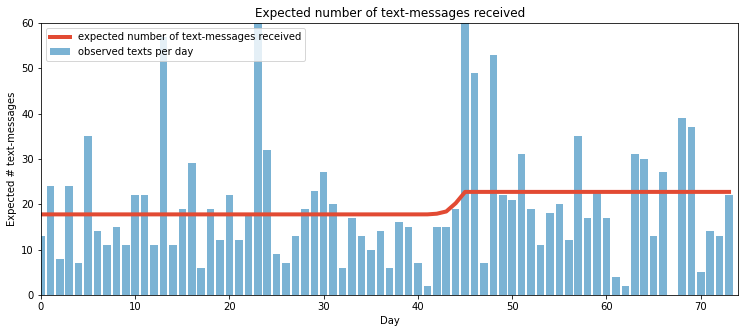

In [11]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

Our analysis shows strong support for believing the user's behavior did change ($\lambda_1$ would have been close in value to $\lambda_2$ had this not been true), and that the change was sudden rather than gradual (as demonstrated by $\tau$'s strongly peaked posterior distribution). 



##### Exercises

1\.  Using `lambda_1_samples` and `lambda_2_samples`, what is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?

In [12]:
#type your code here.
print(lambda_1_samples.mean(),lambda_2_samples.mean())

17.753231252136874 22.715626835715714


2\.  What is the expected percentage increase in text-message rates? `hint:` compute the mean of `lambda_1_samples/lambda_2_samples`. Note that this quantity is very different from `lambda_1_samples.mean()/lambda_2_samples.mean()`.

In [13]:
#type your code here.
a=1-lambda_1_samples/lambda_2_samples
a.mean()

0.21725989231535406

3\. What is the mean of $\lambda_1$ **given** that we know $\tau$ is less than 45.  That is, suppose we have been given new information that the change in behaviour occurred prior to day 45. What is the expected value of $\lambda_1$ now? (You do not need to redo the PyMC3 part. Just consider all instances where `tau_samples < 45`.) What if we actually re-run the code with this information? (technically this should be specified in the sampling algorithm, but we will bound ourselves to prior)

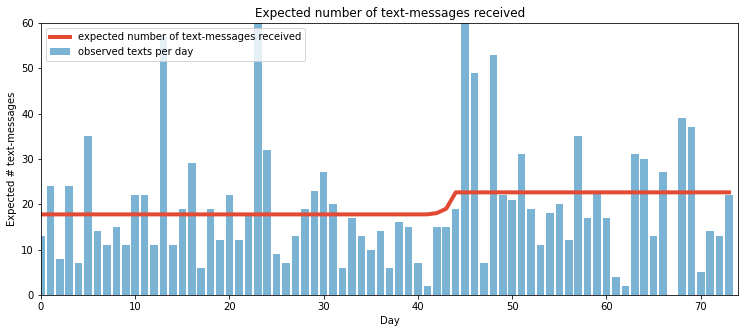

In [14]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
lambda_1_samples=lambda_1_samples[tau_samples<45]
lambda_2_samples=lambda_2_samples[tau_samples<45]
tau_samples=tau_samples[tau_samples<45]

#N = tau_samples.shape[0]
N=tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N
    
#print(len(expected_texts_per_day)," texts ")


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");


In [15]:
print(lambda_1_samples.mean(),lambda_2_samples.mean())

17.751373689085924 22.613195524775392


In [16]:
###with re-running



import pymc3 as pm

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=44)
    #tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data-1)
    
#with model:
    #idx = np.arange(n_count_data) # Index
    idx=np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
#with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

#with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step,
                      return_inferencedata=False)
    
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

print(lambda_1_samples.mean(),lambda_2_samples.mean())




Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 10 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


17.729334637516008 22.529807746034212


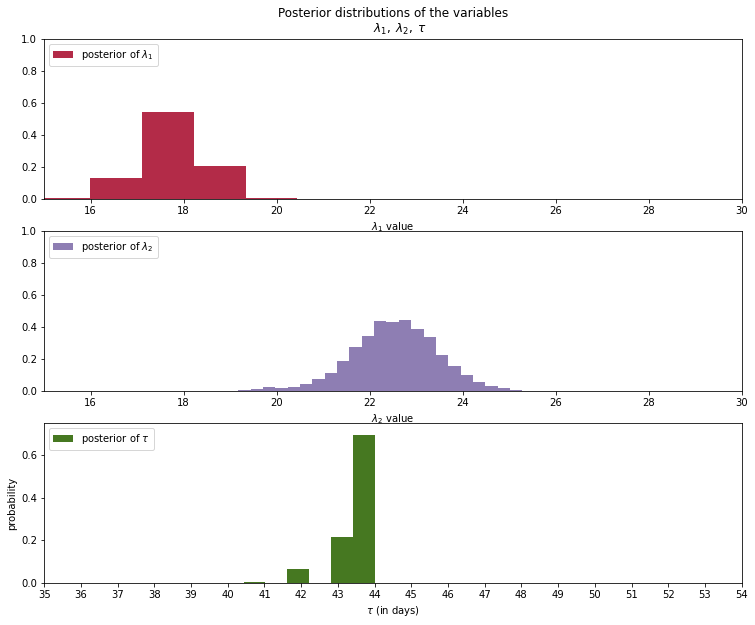

In [17]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");